# **AFL Agent Tutorial: Notebook 03** <a href="https://colab.research.google.com/github/martintb/AFL-tutorial/blob/main/notebooks/03-afl-pipelines-instructor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Decision Pipelines (AI agents) with AFL.double_agent

# Instructor Version

*Author: Tyler Martin - tyler.martin@nist.gov*


## Learning Goals

In this notebook, we will build on the learnings from the scikit-learn exercises by showing how we can build complex, yet encapsulated decision pipelines using the `AFL_agent` codebase.



# Setup

**This may take several minutes to complete, please run ASAP**

Please run this collapsed cell by clicking in the box to the left of *8 cells hidden*. This will `pip install` and `import` all necessary dependencies for this tutorial. There is not need to expand this cell block, but you can if you're interested in looking under the hood.


If you've never used Google Colab before, [this FAQ](https://research.google.com/colaboratory/faq.html) may be useful to skim. It's very similar (and based off of) Jupyter, but divergent in several ways.

**Warning!**

If you disconnect for too long, you'll have to rerun this cell. Any text you type into this notebooks should always be saved, but variables in memory and files can dissappear when you disconnect.

You're free to download this notebook and run it locally if you're inclined, but we will provide no support for this.


In [3]:
!git clone https://github.com/martintb/AFL-tutorial

Cloning into 'AFL-tutorial'...
remote: Enumerating objects: 314, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 314 (delta 18), reused 6 (delta 3), pack-reused 280 (from 1)
Receiving objects: 100% (314/314), 146.17 MiB | 26.95 MiB/s, done.
Resolving deltas: 100% (154/154), done.


In [4]:
!pip install --find-links ./AFL-tutorial/wheels --editable ./AFL-tutorial/
!pip install "AFL_agent[tensorflow] @ git+https://github.com/usnistgov/AFL-agent.git"

Looking in links: ./AFL-tutorial/wheels
Obtaining file:///content/AFL-tutorial
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
Processing ./AFL-tutorial/wheels/tinycc-1.1-py3-none-any.whl (from sasmodels>=1.0.0->AFL-tutorial==0.1.0)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.7 MB/s eta 0:00:00
  Building editable for AFL-tutorial (pyproject.toml) ... done
  Created wheel for AFL-tutorial: filename=afl_tutorial-0.1.0-0.editable-py3-none-any.whl size=6832 sha256=8d485651c41d5dbd8f9e201d7b0ffbcfb29e3afe0abf63bc539d12dcfe421f6a
  Stored in directory: /tmp/pip-ephem-wheel-cache-xpk_rhom/w

In [5]:
import sys
sys.path.insert(0,'./AFL-tutorial')

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import warnings
import os

import plotly.express as px
import plotly.graph_objects as go

import xarray as xr
xr.set_options(display_expand_data=False)

In [8]:
from AFL.double_agent_tutorial import *
from AFL.double_agent_tutorial.instruments.tutorial import *
from AFL.double_agent import *
from AFL.double_agent.TensorFlowExtrapolator import TFGaussianProcessClassifier

PACKAGE_DIR: /content/AFL-tutorial
DATA_DIR: /content/AFL-tutorial/data


In [9]:
np.random.seed(240424)

# Load Virtual Instrument and Create Initial Data

Just as in Notebook 02, we'll need to load our virtual instrument. After loading, we'll create an initial dataset that we'll use to start our active learning campaign.

In [10]:
instrument = get_virtual_instrument()
instrument

In [11]:
composition_list = [
    {'a':1/3,'b':1/3,'c':1/3},
    {'a':0.0,'b':0.5,'c':0.5},
    {'a':0.5,'b':0.0,'c':0.5},
    {'a':0.5,'b':0.5,'c':0.0},
]

input_dataset = instrument.measure_multiple(composition_list)
input_dataset

<xarray.Dataset> Size: 10kB
Dimensions:  (sample: 4, q: 250)
Coordinates:
  * q        (q) float64 2kB 0.003836 0.003915 0.003997 ... 0.6079 0.6205 0.6334
Dimensions without coordinates: sample
Data variables:
    sas      (sample, q) float64 8kB 2.804e+03 2.546e+03 ... 1.956 1.063
    a        (sample) float64 32B 0.3333 0.0 0.5 0.5
    b        (sample) float64 32B 0.3333 0.5 0.0 0.5
    c        (sample) float64 32B 0.3333 0.5 0.5 0.0

The format of the dataset needs to be a little different than what is used in the scikit-learn portions of this tutorial. We'll combine the three composition variables (a,b,c) into a single variable named composition.

In [12]:
input_dataset['composition'] = input_dataset[['c','a','b']].to_array('component').transpose('sample',...)
input_dataset = input_dataset.drop_vars(['c','a','b'])
input_dataset

<xarray.Dataset> Size: 10kB
Dimensions:      (sample: 4, q: 250, component: 3)
Coordinates:
  * q            (q) float64 2kB 0.003836 0.003915 0.003997 ... 0.6205 0.6334
  * component    (component) object 24B 'c' 'a' 'b'
Dimensions without coordinates: sample
Data variables:
    sas          (sample, q) float64 8kB 2.804e+03 2.546e+03 ... 1.956 1.063
    composition  (sample, component) float64 96B 0.3333 0.3333 ... 0.5 0.5

Note that the above code output a dataset with multiple entries in the **sample** dimension. Since the sample dimension does not have a coordinate defined for it, you can index it using integer indices.

Below we show how to plot the **sas** data variable.

In [13]:
plot_sas_plotly(
    input_dataset,
    y='sas',
    plot_type='loglog'
)

We can also plot the compositions using the `plot_ternary` helper function. Remember to double-click the ternary to view the compositions along the edges.

In [14]:
fig = plot_scatter_plotly(
    input_dataset,
    component_variable='composition',
    ternary=True,
)

axis_kw = dict(showgrid=True, gridcolor='black', griddash='dot')
fig.update_layout(
    ternary=dict(aaxis=axis_kw,baxis=axis_kw,caxis=axis_kw,bgcolor='lightgrey')
)

Note that the relative data positions are unchanged, only the magnitude of the axes is changed.

# Introduction to AFL_agent pipelines

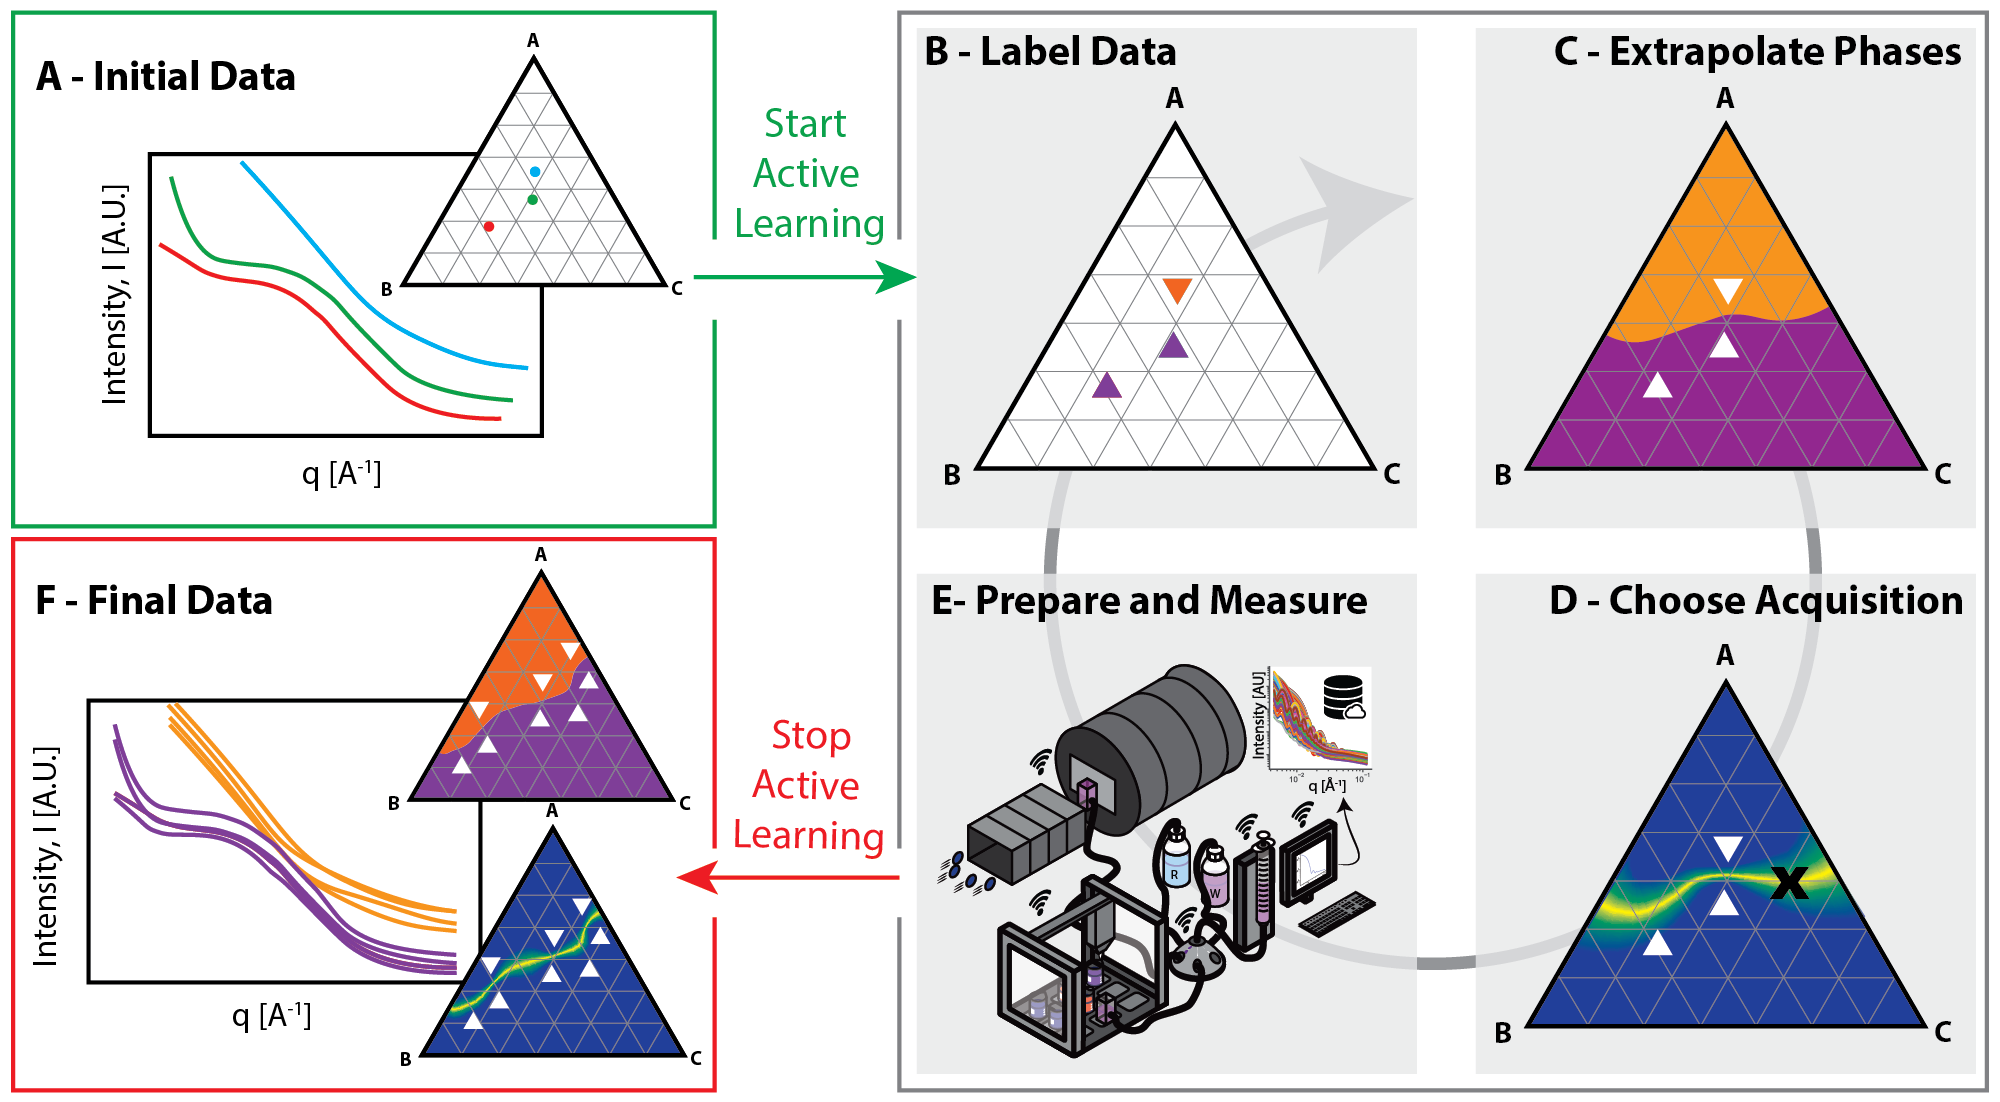


Let's start with the end, first! Below is the fully developed pipeline that we will build up in this tutorial. It looks complicated but, it only has six pipeline operations. These six operations can be further broken up into three suboperations:

- Label Data
    - SavgolFilter
    - Similarity
    - SpectralClustering
- Extrapolate Phases
    - TFGaussianProcessClassifier
- Choose Acquisition
    - MaxValueAF

Note how, for almost every pipeline operation we define an `input_variable` and `output_variable`tput_variable`. These strings define the variable name that the `PipelineOp` will extract from the xarray Dataset for processing. All of the other keyword arguments are for configuring the operation.

In [15]:
with Pipeline() as my_first_pipeline:

    ## Preprocess the SAS measurements
    SavgolFilter(
        input_variable='sas',
        output_variable='derivative',
        dim='q',
        derivative=1
        )

    ## Calculate the pairwise similarity between each measurement
    Similarity(
        input_variable='derivative',
        output_variable='similarity',
        sample_dim='sample',
        params={'metric': 'laplacian','gamma':1e-4}
        )

    ## Label/cluster the SAS measurements by numerical similarity
    SpectralClustering(
        input_variable='similarity',
        output_variable='labels',
        dim='sample',
        params={'n_phases': 2}
        )

    ## Create a barycentric (ternary) grid to extrapolate onto
    BarycentricGrid(
        output_variable='composition_grid',
        components = ['a','b','c'],
        sample_dim='grid',
    )

    ## Extrapolate onto the grid
    TFGaussianProcessClassifier(
        feature_input_variable='composition',
        predictor_input_variable='labels',
        output_prefix='extrap',
        sample_dim='sample',
        grid_variable='composition_grid',
        grid_dim='grid',
    )

    ## Determine next acquisition by finding the max variance
    MaxValueAF(
        input_variables=['extrap_variance'],
        output_variable='next_sample',
        grid_variable='composition_grid',
    )

my_first_pipeline.print()

PipelineOp                               input_variable ---> output_variable
----------                               -----------------------------------
0  ) <SavgolFilter>                      sas ---> derivative
1  ) <SimilarityMetric>                  derivative ---> similarity
2  ) <SpectralClustering>                similarity ---> labels
3  ) <BarycentricGridGenerator>          BarycentricGridGenerator ---> composition_grid
4  ) <TFGaussianProcessClassifier>       ['composition', 'labels', 'composition_grid'] ---> ['extrap_mean', 'extrap_variance']
5  ) <MaxValueAF>                        ['extrap_variance', 'composition_grid'] ---> next_sample

Input Variables
---------------
0) sas
1) BarycentricGridGenerator
2) composition

Output Variables
----------------
0) extrap_mean
1) next_sample


# Building a Pipeline Step by Step

Okay, now let's build up the pipeline step-by-step and observe the output of each operation.

## Step 2: Preprocess SAS Data

Now that we have the composition data processed, we can move on to processing the measurement data. In many cases, smoothing and filtering data can help remove noise and emphasize features in data that you want your agent to focus on.

Here we'll add a `SavgolFilter` operation in order to calculate the first derivative of the measurement data.

In [16]:
with Pipeline() as my_first_pipeline:
       SavgolFilter(
           input_variable='sas',
           output_variable='derivative',
           dim='q',
           window_length=21,
           apply_log_scale=True,
           derivative=1,
           )

my_first_pipeline.print()

PipelineOp                               input_variable ---> output_variable
----------                               -----------------------------------
0  ) <SavgolFilter>                      sas ---> derivative

Input Variables
---------------
0) sas

Output Variables
----------------
0) derivative




Let's go through each argument passed to SavgolFilter:

* `input_variable='sas'`: Specifies the data variable to filter, in this case the raw measurement data
* `output_variable='derivative'`: Names the new variable that will store the filtered/derivative data
* `dim='x'`: Indicates which dimension to apply the filter along (the x-axis values)
* `window_length=50`: Sets the size of the moving window used for filtering - larger values give smoother results
* `apply_log_scale=True`: Takes the log of the x-axis values before filtering, useful for data spanning multiple orders of magnitude
* `derivative=1`: Calculates the first derivative of the data while filtering

We can run the pipeline on the dataset and plot the results.

In [17]:
result_dataset = my_first_pipeline.calculate(input_dataset)
result_dataset

  0%|          | 0/1 [00:00<?, ?it/s]

<xarray.Dataset> Size: 20kB
Dimensions:      (sample: 4, q: 250, component: 3, log_q: 250)
Coordinates:
  * q            (q) float64 2kB 0.003836 0.003915 0.003997 ... 0.6205 0.6334
  * component    (component) object 24B 'c' 'a' 'b'
  * log_q        (log_q) float64 2kB -2.416 -2.407 -2.398 ... -0.2072 -0.1983
Dimensions without coordinates: sample
Data variables:
    sas          (sample, q) float64 8kB 2.804e+03 2.546e+03 ... 1.956 1.063
    composition  (sample, component) float64 96B 0.3333 0.3333 ... 0.5 0.5
    derivative   (sample, log_q) float64 8kB -8.096 -7.879 ... -2.016 -2.195

Now we can plot the results of the `Savgol` filter

In [18]:
plot_sas_plotly(
    result_dataset,
    x='log_q',
    y='derivative',
    xlabel='Log(q)',
    ylabel='dLog(Intensity)/dLog(q)',
    plot_type='linlin'
    )

It should be clear from the visualization that there is one dataset that stands out from the rest.

## Step 2: Calculate Similarity between Measurements

Now that we have preprocessed our data using the Savgol filter, we can calculate the similarity between different measurements. The `Similarity` component computes a similarity matrix between all pairs of samples based on their filtered derivative data. This similarity matrix will be used as input for clustering in the next step.


In [19]:
with my_first_pipeline:
    Similarity(
        input_variable='derivative',
        output_variable='similarity',
        sample_dim='sample',
        params={'metric': 'laplacian','gamma':1e-4}
        )

my_first_pipeline.print()

PipelineOp                               input_variable ---> output_variable
----------                               -----------------------------------
0  ) <SavgolFilter>                      sas ---> derivative
1  ) <SimilarityMetric>                  derivative ---> similarity

Input Variables
---------------
0) sas

Output Variables
----------------
0) similarity


The Similarity component takes the following inputs:

- `input_variable`: The variable to calculate similarity between ('derivative')
- `output_variable`: The variable to store the similarity matrix ('similarity')
- `sample_dim`: The dimension containing different samples ('sample')
- `params`: Dictionary of parameters for similarity calculation
  - `metric`: The similarity metric to use ('laplacian')
  - `gamma`: The scale parameter for the similarity metric (1e-4)

Let's execute the pipeline

In [20]:
result_dataset = my_first_pipeline.calculate(input_dataset)
result_dataset

  0%|          | 0/2 [00:00<?, ?it/s]

<xarray.Dataset> Size: 20kB
Dimensions:      (sample: 4, q: 250, component: 3, log_q: 250, sample_i: 4,
                  sample_j: 4)
Coordinates:
  * q            (q) float64 2kB 0.003836 0.003915 0.003997 ... 0.6205 0.6334
  * component    (component) object 24B 'c' 'a' 'b'
  * log_q        (log_q) float64 2kB -2.416 -2.407 -2.398 ... -0.2072 -0.1983
Dimensions without coordinates: sample, sample_i, sample_j
Data variables:
    sas          (sample, q) float64 8kB 2.804e+03 2.546e+03 ... 1.956 1.063
    composition  (sample, component) float64 96B 0.3333 0.3333 ... 0.5 0.5
    derivative   (sample, log_q) float64 8kB -8.096 -7.879 ... -2.016 -2.195
    similarity   (sample_i, sample_j) float64 128B 1.0 0.9918 ... 0.9727 1.0

We can visualize the similarity matrix.

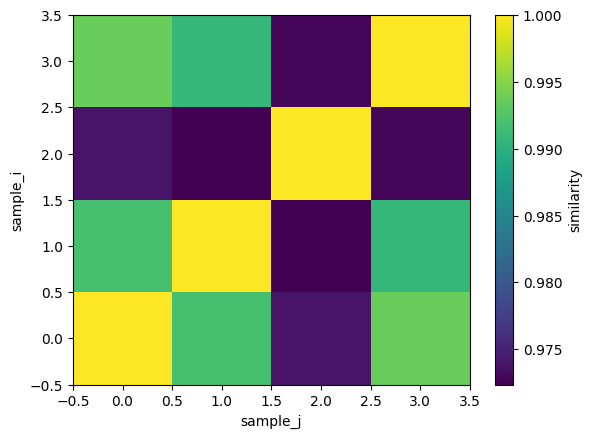

In [21]:
result_dataset.similarity.plot()

Each pixel indexed by (i,j) in this image corresponds to the similarity between measurement i and j. The bright pixels indicate high similarity and the darker pixels reduced similarity. A check on this calculation is that the diagonal should have a perfect similarity = 1.0 because each data is perfectly self similar to itself, i.e. `S(i,i) = S(j,j) = 1.0`

## Step 3: Cluster Measurement Data based on Similarity

Now that we can use the similarity matrix to cluster the data into groups.

In [22]:
with my_first_pipeline:
    SpectralClustering(
        input_variable='similarity',
        output_variable='labels',
        dim='sample',
        params={'n_phases': 2}
        )


my_first_pipeline.print()

PipelineOp                               input_variable ---> output_variable
----------                               -----------------------------------
0  ) <SavgolFilter>                      sas ---> derivative
1  ) <SimilarityMetric>                  derivative ---> similarity
2  ) <SpectralClustering>                similarity ---> labels

Input Variables
---------------
0) sas

Output Variables
----------------
0) labels



The SpectralClustering pipeline operation takes:

 - `input_variable`: The similarity matrix to use for clustering ('similarity')
 - `output_variable`: The variable to store the cluster labels ('labels')
 - `dim`: The dimension containing different samples ('sample')
 - `params`: Dictionary of parameters for clustering
   - `n_phases`: The number of clusters/phases to find (2)

Let's run the pipeline with this new operation

In [23]:
result_dataset = my_first_pipeline.calculate(input_dataset)
result_dataset

  0%|          | 0/3 [00:00<?, ?it/s]

<xarray.Dataset> Size: 20kB
Dimensions:      (sample: 4, q: 250, component: 3, log_q: 250, sample_i: 4,
                  sample_j: 4)
Coordinates:
  * q            (q) float64 2kB 0.003836 0.003915 0.003997 ... 0.6205 0.6334
  * component    (component) object 24B 'c' 'a' 'b'
  * log_q        (log_q) float64 2kB -2.416 -2.407 -2.398 ... -0.2072 -0.1983
Dimensions without coordinates: sample, sample_i, sample_j
Data variables:
    sas          (sample, q) float64 8kB 2.804e+03 2.546e+03 ... 1.956 1.063
    composition  (sample, component) float64 96B 0.3333 0.3333 ... 0.5 0.5
    derivative   (sample, log_q) float64 8kB -8.096 -7.879 ... -2.016 -2.195
    similarity   (sample_i, sample_j) float64 128B 1.0 0.9918 ... 0.9727 1.0
    labels       (sample) int64 32B 0 0 1 0

Plotting the results of this labeling and comparing to the ground truth

In [24]:
fig = plot_scatter_plotly(
    dataset=result_dataset,
    component_variable = 'composition',
    labels='labels',
    ternary=True
    )

axis_kw = dict(showgrid=True, gridcolor='black', griddash='dot')
fig.update_layout(
    ternary=dict(aaxis=axis_kw,baxis=axis_kw,caxis=axis_kw,bgcolor='lightgrey')
)

## Step 4: Extrapolate Cluster Labels

Now we can extrapolate the labels from the `SpectralClustering`. To do this, we'll need to provide a 'grid' to extrapolate over. The grid provides the specific values that we'll evaluate our Gaussian Process over.

In [25]:
with my_first_pipeline:
    BarycentricGrid(
        output_variable='composition_grid',
        components = ['a','b','c'],
        sample_dim='grid',
    )

    TFGaussianProcessClassifier(
        feature_input_variable='composition',
        predictor_input_variable='labels',
        output_prefix='extrap',
        sample_dim='sample',
        grid_variable='composition_grid',
        grid_dim='grid',
    )
my_first_pipeline.print()

PipelineOp                               input_variable ---> output_variable
----------                               -----------------------------------
0  ) <SavgolFilter>                      sas ---> derivative
1  ) <SimilarityMetric>                  derivative ---> similarity
2  ) <SpectralClustering>                similarity ---> labels
3  ) <BarycentricGridGenerator>          BarycentricGridGenerator ---> composition_grid
4  ) <TFGaussianProcessClassifier>       ['composition', 'labels', 'composition_grid'] ---> ['extrap_mean', 'extrap_variance']

Input Variables
---------------
0) sas
1) BarycentricGridGenerator
2) composition

Output Variables
----------------
0) extrap_mean
1) extrap_variance


The GaussianProcessClassifier pipeline operation takes:

- `feature_input_variable`: The composition data to use for training ('compositions')
- `predictor_input_variable`: The labels to predict ('labels')
- `output_prefix`: Prefix for output variables ('extrap')
- `sample_dim`: The dimension containing different samples ('sample')
- `grid_variable`: The grid points to extrapolate to ('composition_grid')
- `grid_dim`: The dimension containing grid points ('grid')

In [26]:
result_dataset = my_first_pipeline.calculate(input_dataset)
result_dataset

  0%|          | 0/5 [00:00<?, ?it/s]

<xarray.Dataset> Size: 71kB
Dimensions:           (q: 250, component: 3, log_q: 250, sample: 4,
                       sample_i: 4, sample_j: 4, grid: 1275)
Coordinates:
  * q                 (q) float64 2kB 0.003836 0.003915 ... 0.6205 0.6334
  * component         (component) object 24B 'c' 'a' 'b'
  * log_q             (log_q) float64 2kB -2.416 -2.407 ... -0.2072 -0.1983
Dimensions without coordinates: sample, sample_i, sample_j, grid
Data variables:
    sas               (sample, q) float64 8kB 2.804e+03 2.546e+03 ... 1.063
    composition       (sample, component) float64 96B 0.3333 0.3333 ... 0.5 0.5
    derivative        (sample, log_q) float64 8kB -8.096 -7.879 ... -2.195
    similarity        (sample_i, sample_j) float64 128B 1.0 0.9918 ... 1.0
    labels            (sample) int64 32B 0 0 1 0
    composition_grid  (grid, component) float64 31kB 1.0 0.0 0.0 ... 0.0 1.0 0.0
    extrap_mean       (grid) int64 10kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    extrap_variance   (grid) float64 10kB 0.4999 0.4998 0.4994 ... 0.4998 0.4999

From this calculation, we get two new data variables: `extrap_mean` and `extrap_variance`. These represent the most likely phase label and the uncertainty of this assignment. First, let's plot the mean function:

In [27]:
fig = plot_surface_plotly(
    dataset=result_dataset,
    component_variable = 'composition_grid',
    labels='extrap_mean',
    ternary=True
    )
fig

Next, the variance:

In [28]:
fig = plot_surface_plotly(
    dataset=result_dataset,
    component_variable = 'composition_grid',
    labels='extrap_variance',
    ternary=True
    )
fig

The second plot is related to our confidence in the label prediction and is a powerful tool for finding label boundaries because, by construction, it is maximized at label boundaries.

## Step 5: Calculate Next Sample

Now that we have a model that can predict phase labels and their uncertainty, we can use this information to select the next sample point. The `MaxValueAF` pipeline operation will select the composition with maximum entropy as the next point to measure, since high entropy indicates regions where the model is most uncertain about the phase label.


In [29]:
with my_first_pipeline:
    MaxValueAF(
        input_variables=['extrap_variance'],
        output_variable='next_sample',
        grid_variable='composition_grid',
    )

my_first_pipeline.print()

PipelineOp                               input_variable ---> output_variable
----------                               -----------------------------------
0  ) <SavgolFilter>                      sas ---> derivative
1  ) <SimilarityMetric>                  derivative ---> similarity
2  ) <SpectralClustering>                similarity ---> labels
3  ) <BarycentricGridGenerator>          BarycentricGridGenerator ---> composition_grid
4  ) <TFGaussianProcessClassifier>       ['composition', 'labels', 'composition_grid'] ---> ['extrap_mean', 'extrap_variance']
5  ) <MaxValueAF>                        ['extrap_variance', 'composition_grid'] ---> next_sample

Input Variables
---------------
0) sas
1) BarycentricGridGenerator
2) composition

Output Variables
----------------
0) extrap_mean
1) next_sample


Let's run the pipeline

In [30]:
result_dataset = my_first_pipeline.calculate(input_dataset)
result_dataset

  0%|          | 0/6 [00:00<?, ?it/s]

<xarray.Dataset> Size: 82kB
Dimensions:           (q: 250, component: 3, log_q: 250, sample: 4,
                       sample_i: 4, sample_j: 4, grid: 1275, AF_sample: 1)
Coordinates:
  * q                 (q) float64 2kB 0.003836 0.003915 ... 0.6205 0.6334
  * component         (component) object 24B 'c' 'a' 'b'
  * log_q             (log_q) float64 2kB -2.416 -2.407 ... -0.2072 -0.1983
Dimensions without coordinates: sample, sample_i, sample_j, grid, AF_sample
Data variables:
    sas               (sample, q) float64 8kB 2.804e+03 2.546e+03 ... 1.063
    composition       (sample, component) float64 96B 0.3333 0.3333 ... 0.5 0.5
    derivative        (sample, log_q) float64 8kB -8.096 -7.879 ... -2.195
    similarity        (sample_i, sample_j) float64 128B 1.0 0.9918 ... 1.0
    labels            (sample) int64 32B 0 0 1 0
    composition_grid  (grid, component) float64 31kB 1.0 0.0 0.0 ... 0.0 1.0 0.0
    extrap_mean       (grid) int64 10kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    extrap_variance   (grid) float64 10kB 0.4999 0.4998 0.4994 ... 0.4998 0.4999
    decision_surface  (grid) float64 10kB 0.9998 0.9994 0.9987 ... 0.9994 0.9998
    next_sample       (AF_sample, component) float64 24B 0.9388 0.06122 0.0

Let's plot the next composition on the mean and entropy plots:

In [31]:
fig = plot_surface_plotly(
    dataset=result_dataset,
    component_variable = 'composition_grid',
    labels='extrap_variance',
    ternary=True
    )

fig.add_scatterternary(
        a=[result_dataset.next_sample.values[0,0]],
        b=[result_dataset.next_sample.values[0,1]],
        c=[result_dataset.next_sample.values[0,2]],
        mode='markers',
)
fig

See that the red X is placed near the boundary of the two phases. Running the pipeline several times, you should see the X move about the bright region of entropy. This is because the `MaxValueAF` acquisition function doesn't choose the absolute maximum, but rather randomly chooses from the top `acquisition_rtol` percent of the entropy.

# A Simple Active Learning Loop

With that, we have a full `Pipeline` which defines the behavior of a decision agent! Let's view the whole pipeline defined in a single context:

In [35]:

with Pipeline() as my_first_pipeline:

    SavgolFilter(
        input_variable='sas',
        output_variable='derivative',
        dim='q',
        derivative=1
        )

    Similarity(
        input_variable='derivative',
        output_variable='similarity',
        sample_dim='sample',
        params={'metric': 'laplacian','gamma':1e-4}
        )

    SpectralClustering(
        input_variable='similarity',
        output_variable='labels',
        dim='sample',
        params={'n_phases': 2}
        )

    BarycentricGrid(
        output_variable='composition_grid',
        components = ['a','b','c'],
        sample_dim='grid',
    )


    TFGaussianProcessClassifier(
        feature_input_variable='composition',
        predictor_input_variable='labels',
        output_prefix='extrap',
        sample_dim='sample',
        grid_variable='composition_grid',
        grid_dim='grid',
    )

    MaxValueAF(
        input_variables=['extrap_variance'],
        output_variable='next_sample',
        grid_variable='composition_grid',
    )

my_first_pipeline.print()

PipelineOp                               input_variable ---> output_variable
----------                               -----------------------------------
0  ) <SavgolFilter>                      sas ---> derivative
1  ) <SimilarityMetric>                  derivative ---> similarity
2  ) <SpectralClustering>                similarity ---> labels
3  ) <BarycentricGridGenerator>          BarycentricGridGenerator ---> composition_grid
4  ) <TFGaussianProcessClassifier>       ['composition', 'labels', 'composition_grid'] ---> ['extrap_mean', 'extrap_variance']
5  ) <MaxValueAF>                        ['extrap_variance', 'composition_grid'] ---> next_sample

Input Variables
---------------
0) sas
1) BarycentricGridGenerator
2) composition

Output Variables
----------------
0) extrap_mean
1) next_sample


In [38]:
running_dataset = input_dataset.copy()

n_steps = 10
for step in tqdm(np.arange(n_steps)):
    result_dataset = my_first_pipeline.calculate(running_dataset, disable_progress_bar=True)

    # convert next_sample into list of dictionaries
    next_sample_list = result_dataset['next_sample'].to_pandas().to_dict(orient='records')

    # conduct virtual measurement
    new_measurement = instrument.measure_multiple(next_sample_list)
    new_measurement['composition'] = new_measurement[['c','a','b']].to_array('component').transpose('sample',...)
    new_measurement = new_measurement.drop_vars(['c','a','b'])

    # update measurement list
    running_dataset = xr.concat([running_dataset, new_measurement], dim='sample')

  0%|          | 0/10 [00:00<?, ?it/s]

In [42]:
fig1 = plot_surface_plotly(
    dataset=result_dataset,
    component_variable = 'composition_grid',
    labels='extrap_variance',
    ternary=True
    )

fig2 = plot_scatter_plotly(
    dataset=result_dataset,
    component_variable = 'composition',
    labels='labels',
    ternary=True
    )

for trace in fig2.data:
    fig1.add_trace(trace)
fig1

# Conclusion

In this tutorial, we learned how to build pipelines in using `AFL.double_agent` by:

- Creating a new pipeline using `Pipeline()`
- Adding data processing steps like normalization and derivative calculation
- Implementing spectral clustering for phase identification
- Using Gaussian Process classification to extrapolate phase boundaries
- Adding active learning with acquisition functions to guide further sampling
- Visualizing the pipeline structure and results at each step

The pipeline we built demonstrates a complete workflow - from raw data processing through machine learning and active learning. This modular approach allows us to easily modify individual components while maintaining a clear data flow between steps.

For more examples of AFL pipelines and components, check out the other tutorials and examples in the documentation.

